In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from skimage import io
import time
import ast 
from PIL import *
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# subset / old csv
# df = pd.read_csv('temp.csv')

# area larger than 1000
df = pd.read_csv('area_larger_than_1000.csv')

# full dataset 
# df = pd.read_csv('large_nodules_png_bounding_box.csv')

# subset of dataset (25%)
# _ , X_random, = train_test_split(df, test_size=0.25, random_state=0)
# X_random.to_csv('subset.csv',index=False)
# df = X_random

# df.iloc[0,0]

# delete smaller boxes
# df = pd.read_csv('large_nodules_png_bounding_box.csv')
# df_filtered = df[df['areas'] >= 50]  
# df_filtered.to_csv("df_filtered.csv", index = False)
# df = pd.read_csv("df_filtered.csv")
df

,path,imageName,SOPInstanceUID,boxes,areas
0,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000172.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.358253510231...,"[[337.0, 189.0, 376.0, 224.0]]",1365.0
1,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000174.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.332771657417...,"[[335.0, 186.0, 375.0, 225.0]]",1560.0
2,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000019.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.133221309761...,"[[333.0, 189.0, 369.0, 219.0]]",1080.0
3,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000175.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.291261298826...,"[[334.0, 189.0, 374.0, 218.0]]",1160.0
4,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000033.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.122854262319...,"[[112.0, 139.0, 156.0, 189.0]]",2200.0
...,...,...,...,...,...
471,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000119.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.787525847146...,"[[316.0, 313.0, 350.0, 349.0]]",1224.0
472,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000081.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.216953803063...,"[[319.0, 307.0, 350.0, 344.0]]",1147.0
473,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000056.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.182307837643...,"[[313.0, 308.0, 352.0, 346.0]]",1482.0
474,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000056.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.182307837643...,"[[181.0, 173.0, 208.0, 211.0]]",1026.0


In [4]:
print(max(df['areas']), min(df['areas']))

2880.0 1008.0


In [5]:
onlyMax = []
for index, row in df.iterrows():
    img_name = (row.path)
    image = cv2.imread(img_name) 
#     print('og: Min: %.3f, Max: %.3f' % (image.min(), image.max()))
    if (image.max() < 255.00):
        onlyMax.append(row)
df = pd.DataFrame(onlyMax)
df

,path,imageName,SOPInstanceUID,boxes,areas
74,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000111.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.299779260537...,"[[180.0, 280.0, 227.0, 305.0]]",1175.0
75,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000055.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.331499919326...,"[[180.0, 278.0, 233.0, 304.0]]",1378.0
76,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000097.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.464392629392...,"[[181.0, 276.0, 222.0, 312.0]]",1476.0
118,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000107.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.251703689379...,"[[397.0, 355.0, 434.0, 383.0]]",1036.0
119,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000081.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.182968775758...,"[[394.0, 350.0, 437.0, 384.0]]",1462.0
...,...,...,...,...,...
462,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000177.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.336351461606...,"[[169.0, 328.0, 202.0, 379.0]]",1683.0
463,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000258.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.293342189867...,"[[169.0, 327.0, 203.0, 379.0]]",1768.0
464,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000275.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.186316898017...,"[[178.0, 331.0, 204.0, 376.0]]",1170.0
465,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000133.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.275507735707...,"[[169.0, 327.0, 204.0, 379.0]]",1820.0


In [6]:
# # gamma transformation

# def getClosest(target, array):
#     closest = -1;
#     for element in array:
#         if (closest == -1):
#             closest = element
#         if (abs(target - closest) > abs(element - target)):
#             closest = element
#     return array.index(closest)

# def adjust_gamma(image, gamma=1.0):
#     # build a lookup table mapping the pixel values [0, 255] to
#     # their adjusted gamma values
#     invGamma = 1.0 / gamma
#     table = np.array([((i / 255.0) ** invGamma) * 255
#         for i in np.arange(0, 256)]).astype("uint8")
#     # apply gamma correction using the lookup table
#     return cv2.LUT(image, table)
# count = 0
# mean = []
# normalized_mean = []
# gamma_mean = []

# normalized_gamma = []
# for index, row in df.iterrows():
#     img_name = (row.path)
#     image = cv2.imread(img_name) 
    
#     if (np.mean(image) < 50):
#         test = adjust_gamma(image, 12)
#         boxes = ast.literal_eval(row.boxes)
#         for i in boxes:
#             ymin, ymax = i[1],i[3] #ymin ymax        
#             xmin, xmax = (i[0]), (i[2]) #xmin, xmax
#         normalized = (test - test.min())/(test.max() - test.min()) * 255.0
# #         fig, axarr = plt.subplots(1,3, figsize=(10,10))
# #         print(np.mean(image), np.mean(test), np.mean(normalized))
# #         rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# #         axarr[0].add_patch(rect)
# #         axarr[0].imshow(image, cmap='gray')
# #         axarr[1].imshow(test, cmap='gray')
# #         axarr[2].imshow(normalized, cmap='gray')
# #         plt.show()
#         if (np.mean(test) > 50):
#             count += 1
# #             print(test.max(), test.min())
#             gamma_mean.append(row)
#     else:
#         test = adjust_gamma(image, 0.5)
#         boxes = ast.literal_eval(row.boxes)
#         for i in boxes:
#             ymin, ymax = i[1],i[3] #ymin ymax        
#             xmin, xmax = (i[0]), (i[2]) #xmin, xmax
# #         fig, axarr = plt.subplots(1,2, figsize=(10,10))
# #         print(row.path)
# #         print(np.mean(image), np.mean(test))
# #         rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# #         axarr[0].add_patch(rect)
# #         axarr[0].imshow(image, cmap='gray')
# #         axarr[1].imshow(test, cmap='gray')
# #         plt.show()
#         if (np.mean(test) < 120):
#             count += 1
# #             print(test.max(), test.min())
#             gamma_mean.append(row)
# print(count)

# df = pd.DataFrame(gamma_mean)
# df

# # potentially remove:
# #LIDC-IDRI-0702
# #LIDC-IDRI-0976
# #LIDC-IDRI-0340

In [7]:
# split dataset into 60, 20, 20 
train_data, test_data = train_test_split(df, test_size=0.40, random_state=2020)
valid_data, test_data = train_test_split(test_data, test_size=0.50, random_state=2020)
train_data.index = np.arange(len(train_data))
valid_data.index = np.arange(len(valid_data))
test_data.index = np.arange(len(test_data))

In [8]:
train_data.to_csv("large_nodules_train.csv", index=False)
valid_data.to_csv("large_nodules_valid.csv", index=False)
test_data.to_csv("large_nodules_test.csv", index=False)

In [9]:
from torchvision import transforms
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

train_transform = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.RandomResizedCrop(512),
        transforms.CenterCrop(512),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
#         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
#         transforms.Normalize([0.18082525, 0.18082525, 0.18082525],[0.1896516, 0.1896516, 0.1896516])])
#         transforms.Normalize([0.34390035, 0.34390035, 0.34390035], [0.31606647, 0.31606647, 0.31606647])])


validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(512),
        transforms.ToTensor()])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class Faster_RCNN_Dataloader(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        # get image path
        img_name = (self.data_frame.iloc[idx, 0])
        
#         # open image 
#         image = io.imread(img_name)
#         # 3 channels
#         image = np.array(image)
        image = cv2.imread(img_name) # Read image with cv2
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        # transform image? 
#         plt.imshow(image)
        d = {}
    
        # gamma transformation
#         gamma = [1.0]
#         if (np.mean(image) > 100):
#             gammma = [0.5]
#         elif(np.mean(image) < 50):
#             gamma = [10.0, 11.0, 12.0]
#         else:
#             gamma = [0.5, 1.0, 1.5]
#         gamImages = []
#         gamMean = []
#         for gam in gamma:
#             gam_image = adjust_gamma(image, gam)
#             gamImages.append(gam_image)
#             gamMean.append(np.mean(gam_image))
#         indexImage = getClosest(95, gamMean)
#         image = gamImages[indexImage]
        image = (image - image.min())/(image.max() - image.min()) * 255.0
#         print('normalized: Min: %.3f, Max: %.3f' % (image.min(), image.max()))
        
        if self.transform:
            image = self.transform(np.uint8(image))
        
            # confirm pixel range is 0-255

#             print('tensor: Min: %.3f, Max: %.3f' % (image.min(), image.max()))
#             print(image.shape)
            d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
            d['labels'] = torch.ones([1], dtype=torch.int64)
#             d['labels'] = torch.ones((1, 1),  dtype=torch.int64)
#         plt.imshow(image.squeeze().numpy())
        else:
            d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
            d['labels'] = torch.ones([1], dtype=torch.int64)

        
        return image, d

# change dataloader output to lists.
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    return list(xx), list(yy)

In [10]:
train_df_path = 'large_nodules_train.csv'
validate_df_path = 'large_nodules_valid.csv'
test_df_path = 'large_nodules_test.csv'

transformed_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform),
                       'validate':Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform),
                       'test':Faster_RCNN_Dataloader(test_df_path, transform=validation_transform)}
bs = 8

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, collate_fn = pad_collate, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}


# one dataloader / phase, may be too memory intensive...

# train_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform)}
# validate_dataset = {'validate': Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform)}
# test_dataset = {'test': Faster_RCNN_Dataloader(test_df_path)}

# bs = 16 #if bigger, running out of memory in p100

# train_dataloader = {x : DataLoader(train_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['train']}
# validate_dataloader = {x : DataLoader(validate_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['validate']}
# test_dataloader = {x : DataLoader(test_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['test']}
# data_sizes ={len(dataset[x]) for x in ['train']}

PNG
(512, 512)
L


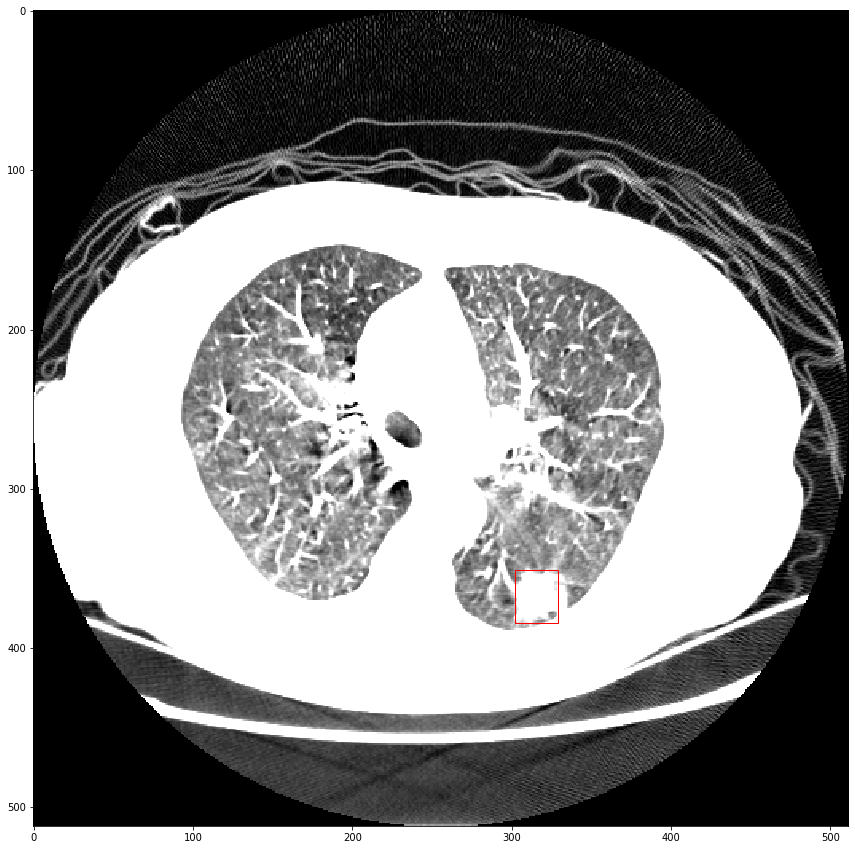

In [11]:
image = Image.open("/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.png")
# plt.imshow(image, cmap="bone")
print(image.format)
print(image.size)
print(image.mode)

path = '/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.png'
boxes = "[[302.0, 351.0, 329.0, 384.0]]"

def box_png(path, boxes):
    boxes = ast.literal_eval(boxes)
    for i in boxes:
            ymin, ymax = i[1],i[3] #ymin ymax        
            xmin, xmax = (i[0]), (i[2]) #xmin, xmax
#     im = np.array(Image.open(path), dtype=np.uint8)
    image = cv2.imread(path) # Read image with cv2
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig,ax = plt.subplots(1, figsize=(15,15))
    ax.imshow(image, cmap='gray')
    rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
box_png(path, boxes)

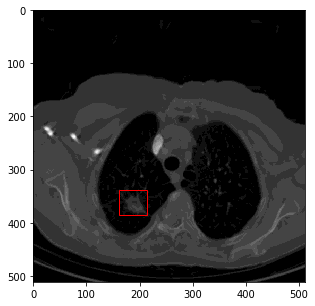

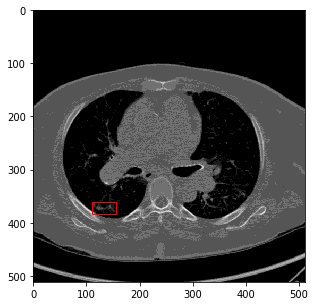

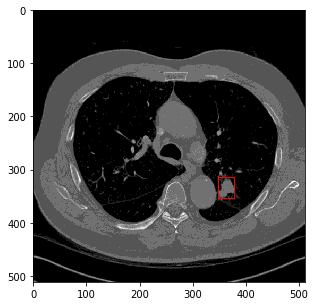

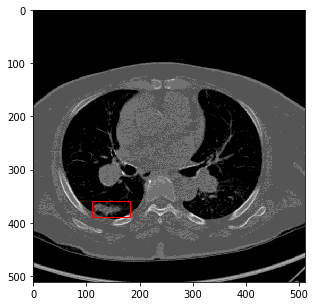

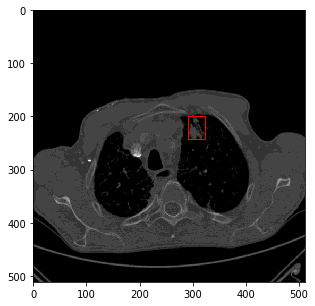

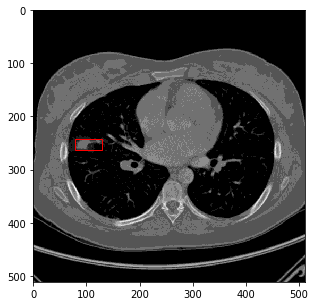

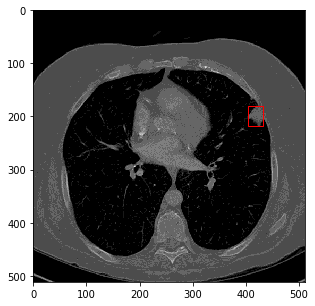

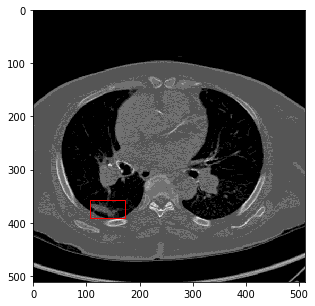

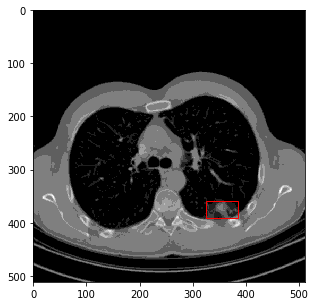

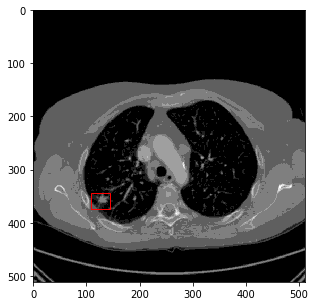

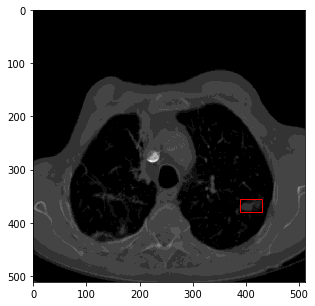

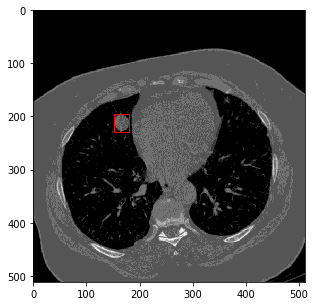

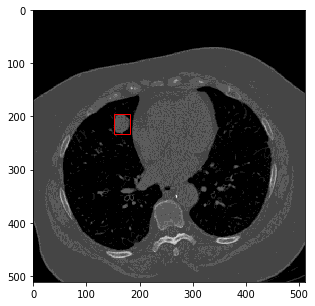

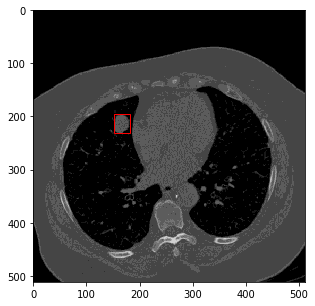

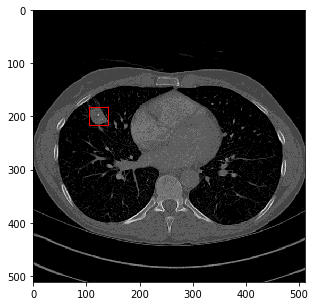

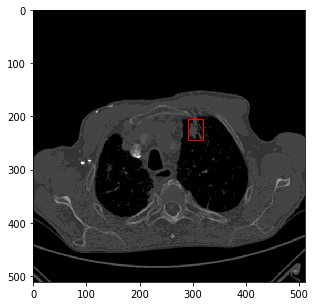

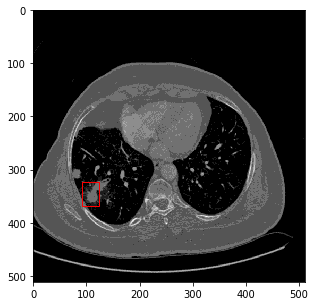

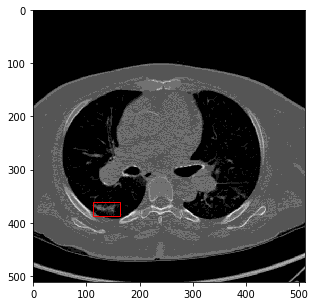

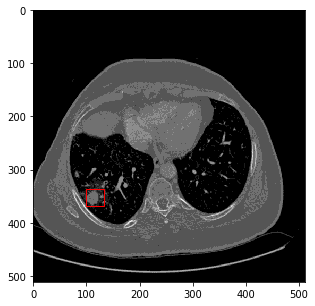

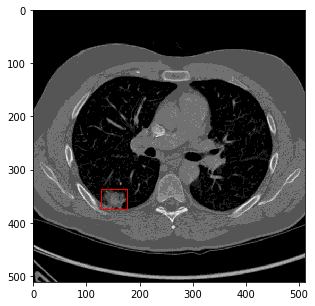

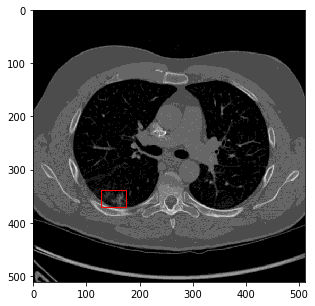

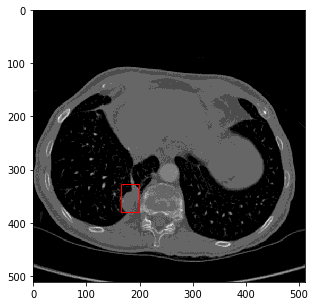

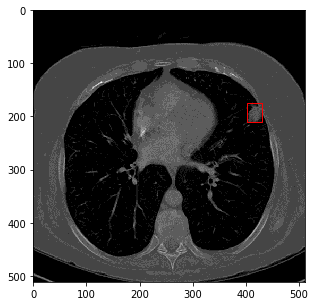

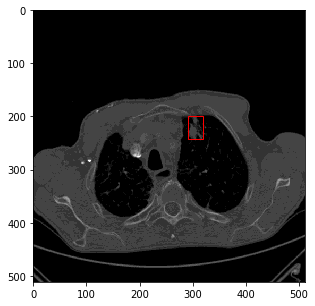

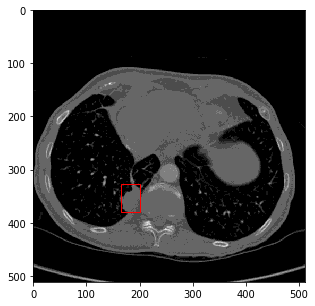

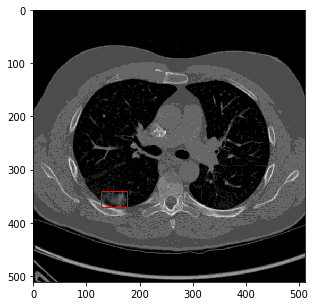

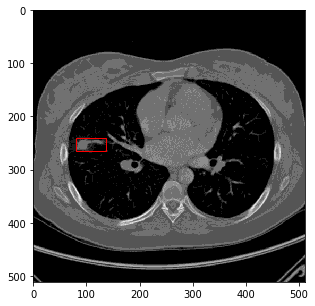

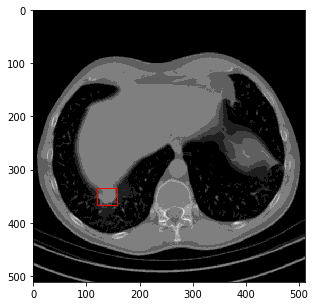

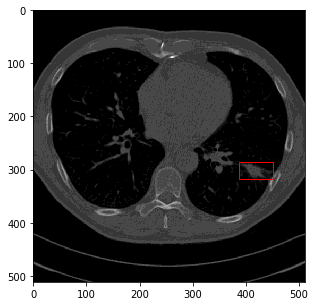

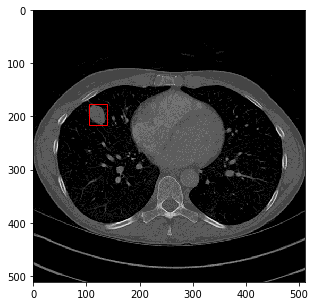

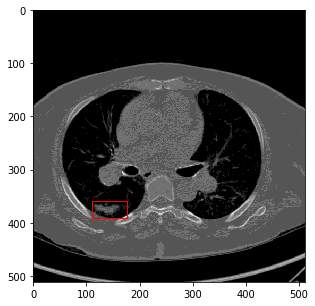

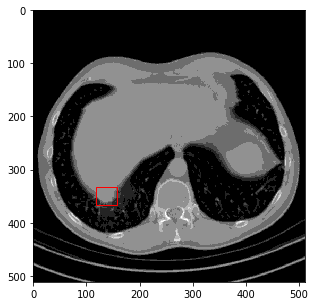

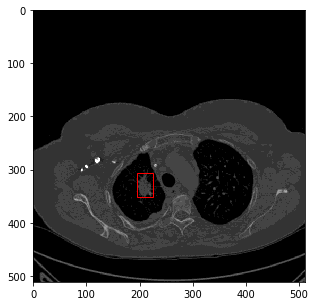

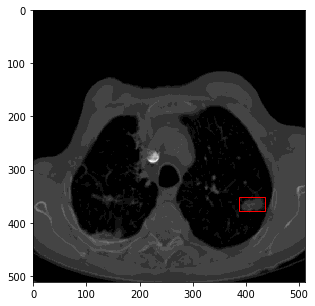

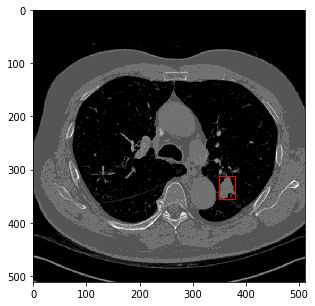

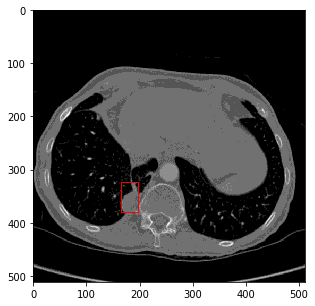

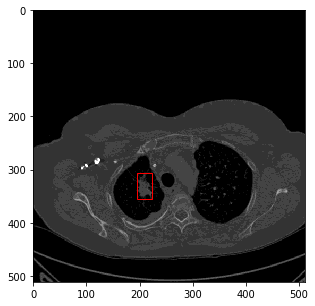

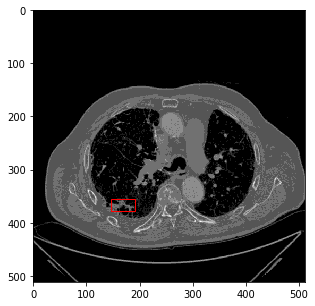

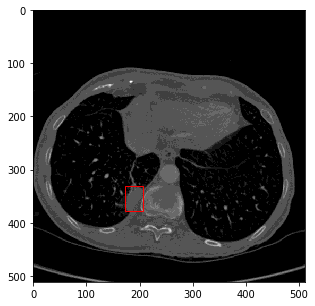

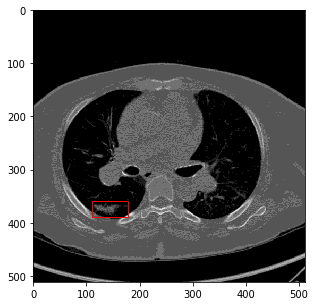

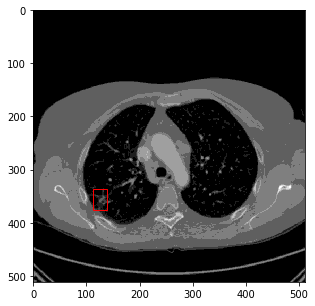

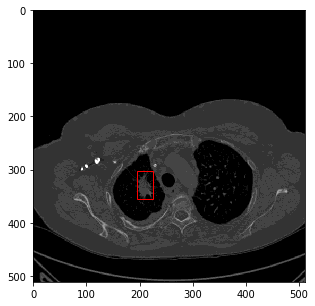

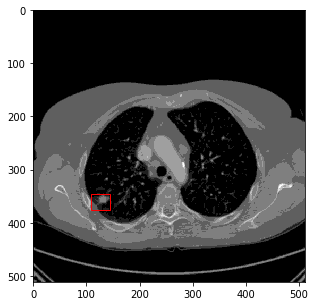

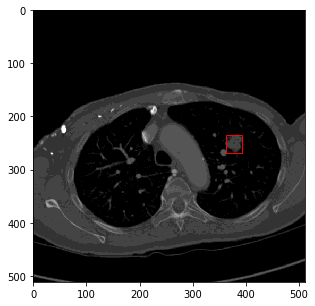

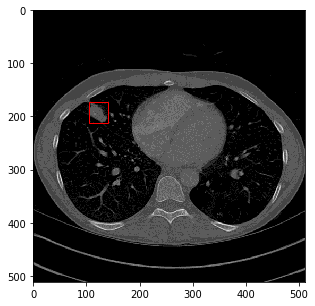

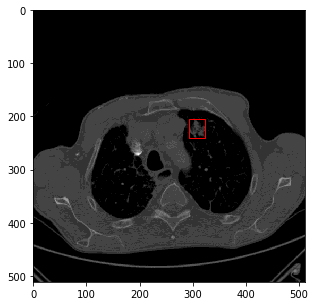

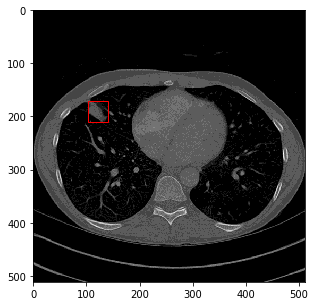

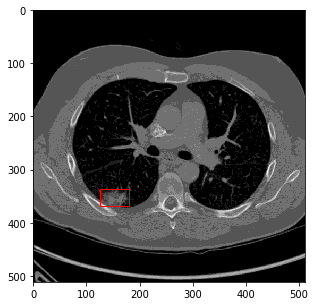

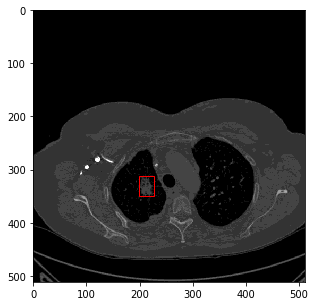

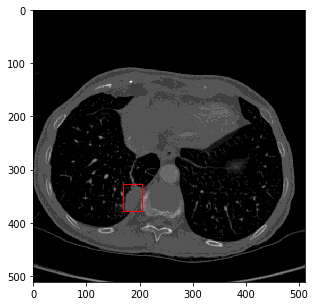

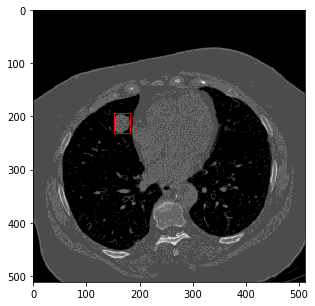

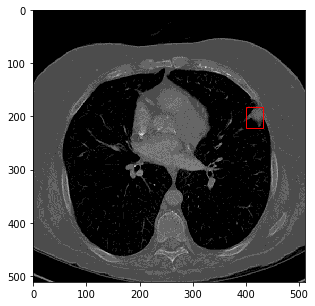

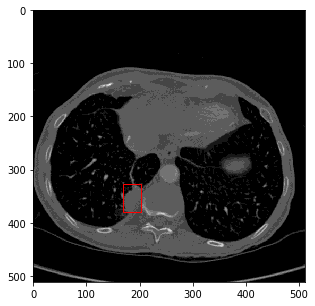

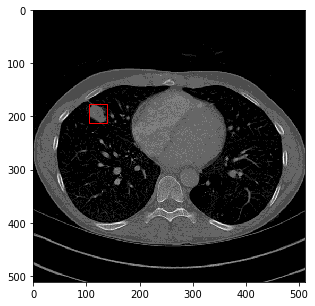

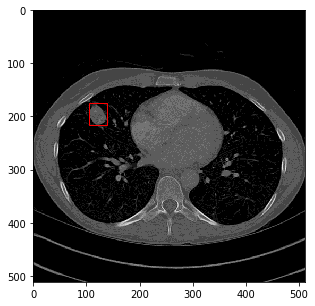

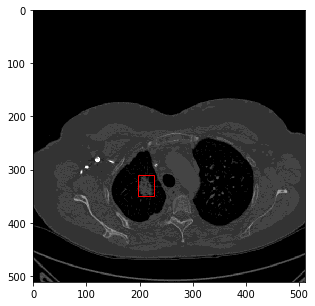

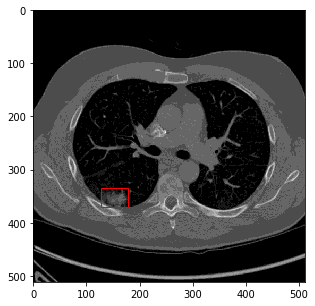

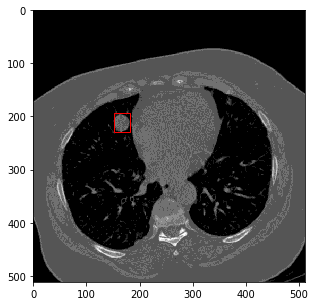

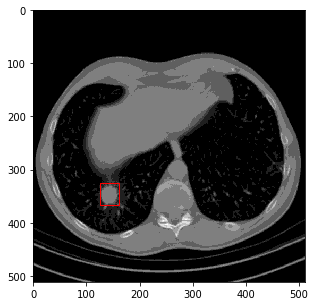

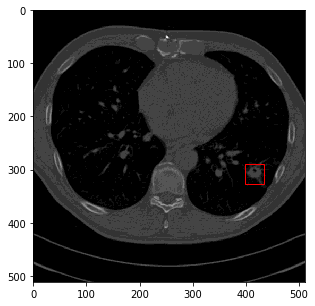

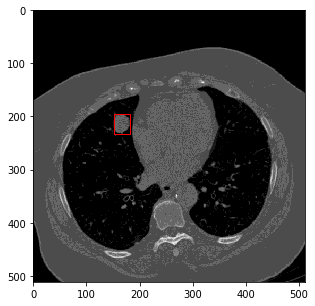

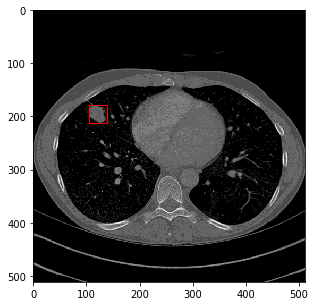

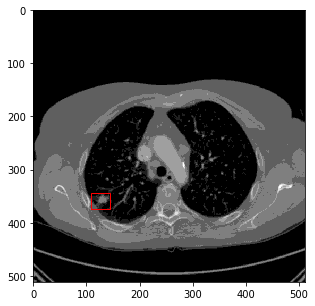

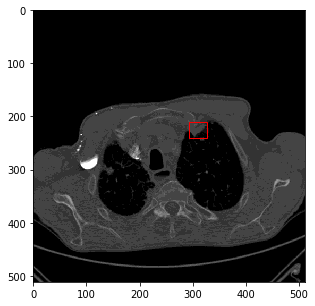

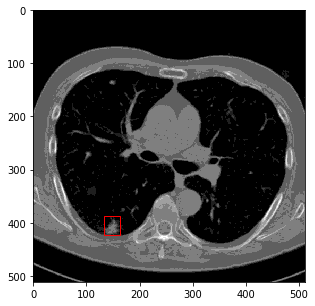

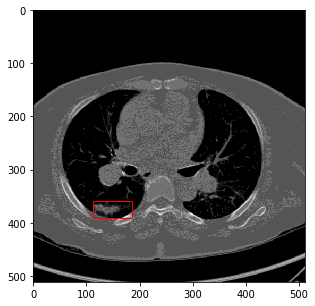

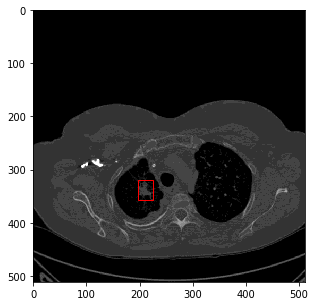

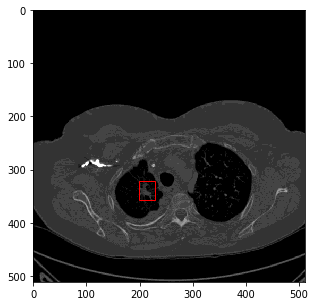

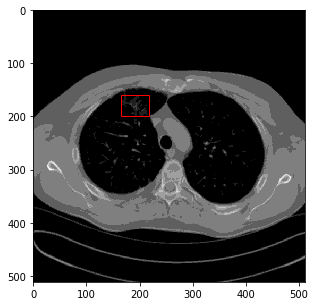

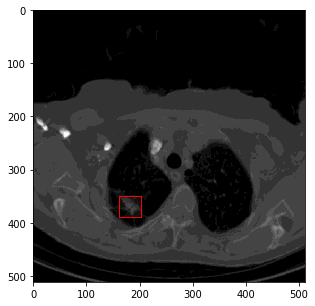

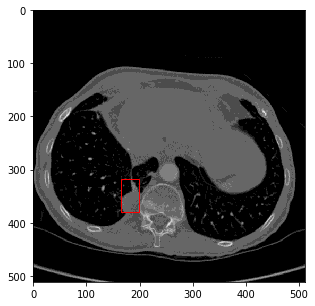

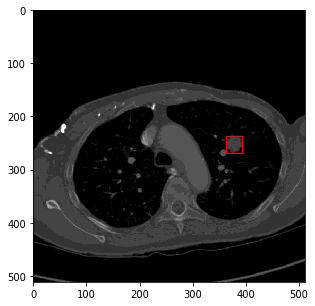

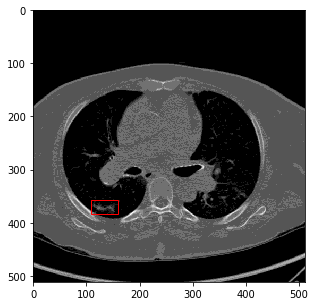

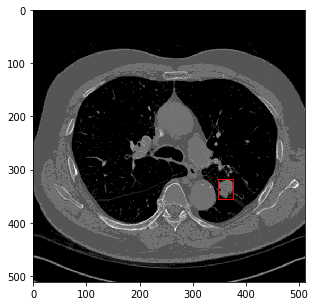

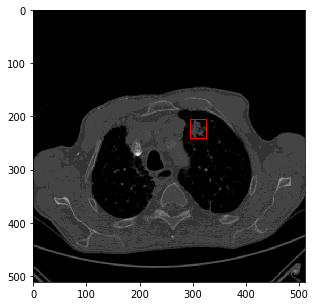

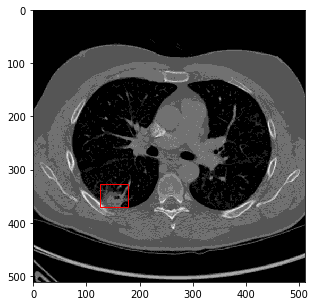

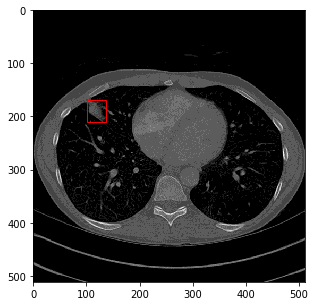

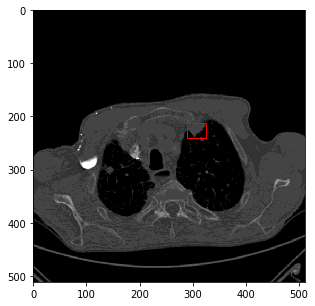

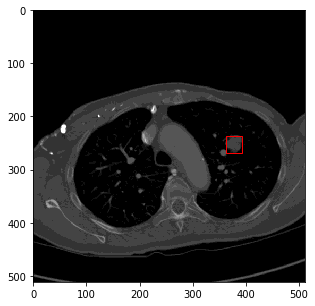

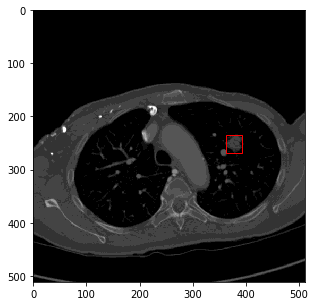

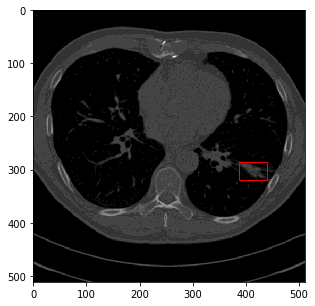

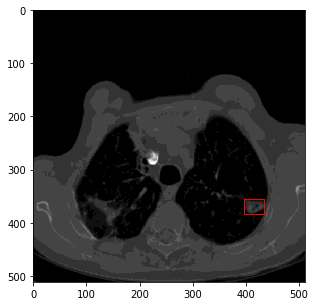

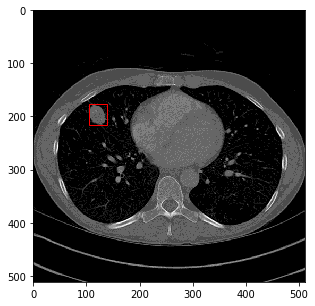

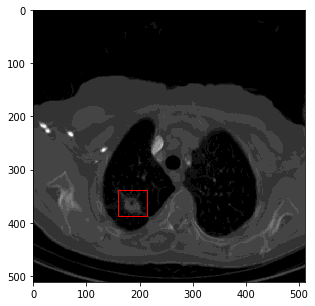

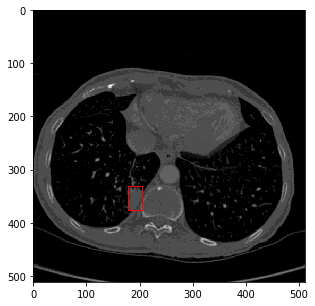

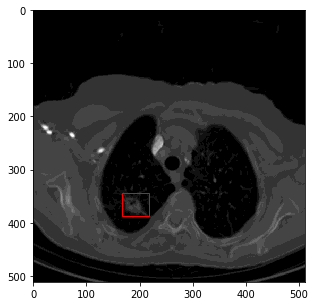

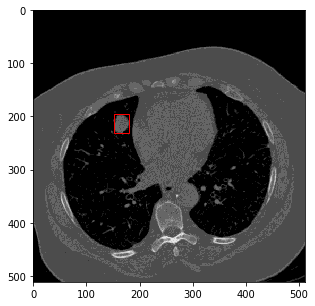

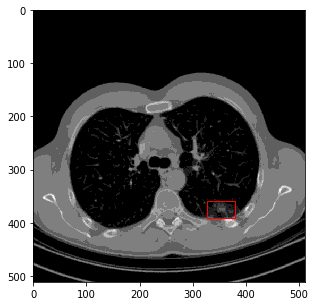

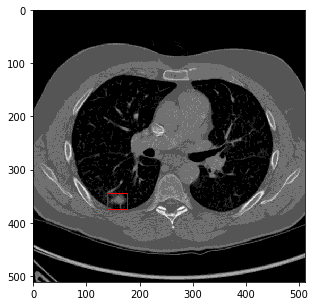

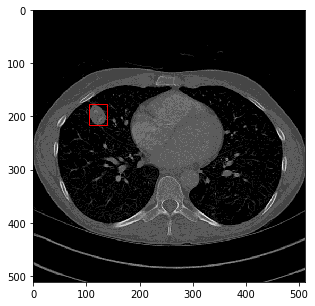

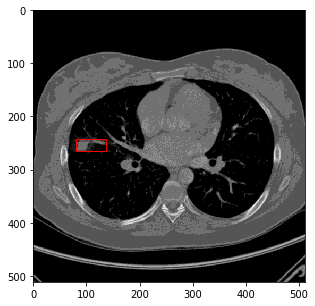

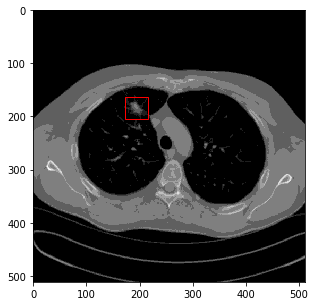

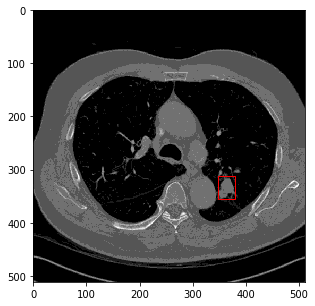

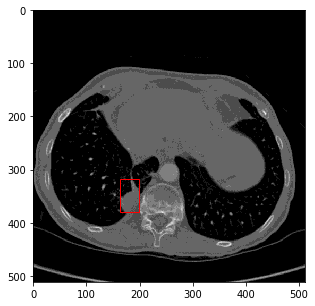

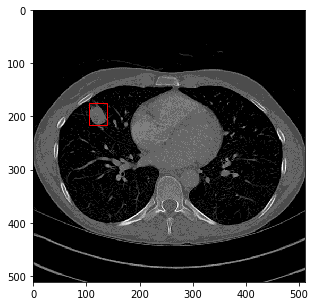

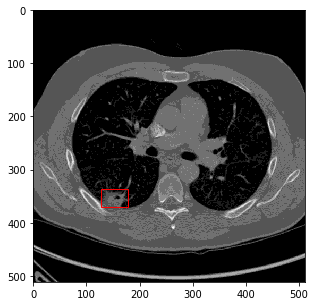

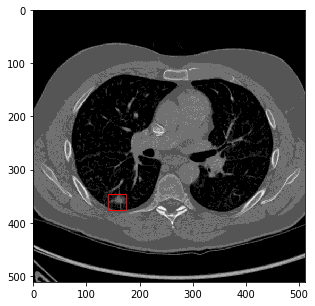

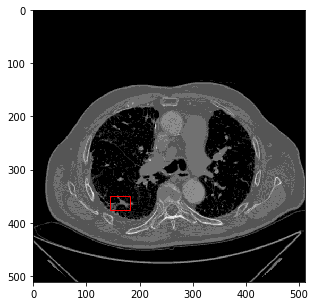

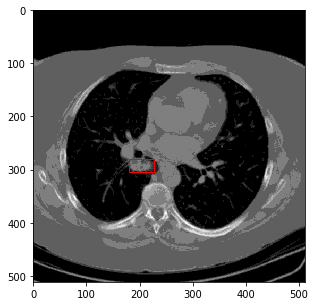

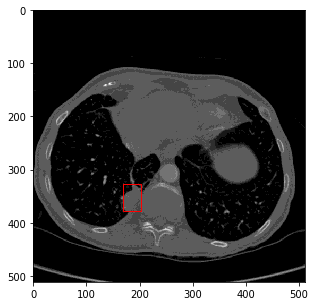

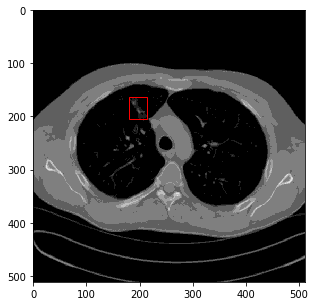

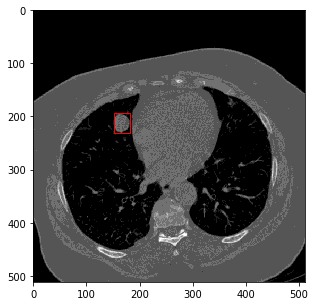

In [12]:
# check if dataloader loaded correctly
# images1, targets1 = next(iter(train_dataloader['train']))
# images2, targets2 = next(iter(validate_dataloader['validate']))
# images3, targets3 = next(iter(test_dataloader['test']))

# to check dim of list dataloader
# len(images) = batch
# len(images[0]) = channel
# len(images[0]) = height
# len(images[0]) = width

# testing dataloader 
images4, targets4 = next(iter(dataloader['train']))

# for i in targets4[0]['boxes'].numpy():
#     ymin, ymax = i[1],i[3] #ymin ymax        
#     xmin, xmax = i[0], i[2] #xmin, xmax
# fig,ax = plt.subplots(1, figsize=(5,5))
# ax.imshow(images4[0][1].squeeze().numpy(), cmap='gray')
# rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)
# plt.show()

for images, targets in dataloader['train']:
    for i, img in enumerate(images):
        for i in targets[i]['boxes'].numpy():
            ymin, ymax = i[1],i[3] #ymin ymax        
            xmin, xmax = i[0], i[2] #xmin, xmax
            fig,ax = plt.subplots(1, figsize=(5,5))
            ax.imshow(img[1].squeeze().numpy(), cmap="gray")
            rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
            plt.show()

In [13]:
pop_mean1 = []
pop_std1 = []

pop_mean2 = []
pop_std2 = []

pop_mean3 = []
pop_std3 = []
for i, data in enumerate(dataloader['train']):
    for i in data[0]:

        numpy_image = i.numpy()
#         print(len(numpy_image))
        mean1 = np.mean(numpy_image[0])
        mean2 = np.mean(numpy_image[1])
        mean3 = np.mean(numpy_image[2])
        
        std1 = np.std(numpy_image[0])
        std2 = np.std(numpy_image[1])
        std3 = np.std(numpy_image[2])
        
        pop_mean1.append(mean1)
        pop_mean2.append(mean2)
        pop_mean3.append(mean3)
        
        pop_std1.append(std1)
        pop_std2.append(std2)
        pop_std3.append(std3)

pop_mean1 = np.array(pop_mean1).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)
pop_mean2 = np.array(pop_mean2).mean(axis=0)
pop_std2 = np.array(pop_std2).mean(axis=0)
pop_mean3 = np.array(pop_mean3).mean(axis=0)
pop_std3 = np.array(pop_std3).mean(axis=0)
print(pop_mean1,pop_mean2,pop_mean3, pop_std1, pop_std2, pop_std3)

0.1464788 0.1464788 0.1464788 0.17285866 0.17285866 0.17285866


In [14]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nodule) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios

# anchor_generator = AnchorGenerator(sizes=((4, 8, 16, 32, 36, 40, 48, 49, 56, 64, 72),),
#                                    aspect_ratios=((0.25, 0.5, 0.75, 1.0, 1.25, 1.5),))

# areas > 1000
anchor_generator = AnchorGenerator(sizes=((36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56),),
                                   aspect_ratios=((1.0),))

# anchor_generator = AnchorGenerator(sizes=((36, 40, 48, 49, 56, 64, 72),),
#                                    aspect_ratios=((.75, 1.0, 1.25, 1.5),))

# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   rpn_nms_thresh = .9).to(device)

# tried to run not pretrained.
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2).to(device)

# for multiple nodes
torch.nn.DataParallel(model)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0005)

lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

# unused 
cel = nn.MSELoss() 

In [16]:
# move dict/lists to gpu 
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [17]:
classes = ['__background__', 'nodule']

In [18]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [19]:
def train_model(model, dataloader,optimizer, scheduler, loss_fn, num_epochs = 10, verbose = True):
    acc_dict = {'train':[]}
    loss_dict = {'train':[], 'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    
    epochLossTrain = list()
#     epochAccTrain = list()
#     epochLossValidate = list()
    epochAccValidate = list()
    epochAccBestScore = list()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        losslist = []
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            maxIOUs = [-1]
            bestScore = [-1]
            if p == 'train':
                model.train()
            else:
                model.eval()   
            num = 0 # calculate which batch --> enumerate not working
            loss = 0.0
            noPredictions = 0
            bestScore = []
            list_max = []
            for image, target in dataloader[p]:
#                 optimizer.zero_grad()
                # move data to gpu
#                 plt.imshow(image[0].squeeze().numpy())
                image = move_to(image,device)
                target = move_to(target,device)
                if (num % int(len(dataloader[p])/4) == 0):
                    print('{} set | epoch: {:3d} | {:6d}/{:6d} batches'.format(p, i, num, len(dataloader[p])))
                num = num + 1
                
                if p == 'train':
                    # loss = sum of all 4 losses returned
                    output = model((image), target)
                    loss = sum(loss for loss in output.values())
                if p == 'validate':
                    # helps with memory 
                    with torch.no_grad():
                        model.eval()  
                        output = model((image))
                        pred_score = [0] # confidence score
                        pred_boxes = [] # bounding box
                        pred_class = [] # predicted class
                        maxIOUs = [0]
                        # loop through output (len(output) = batch size )
                        for j, out in enumerate(output):
                            # documentation: ['boxes'] = [x1, y1, x2, y2]
                            pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
                            pred_score = list(out['scores'].cpu().detach().numpy())
                            pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]
                            
                            # get correct label
                            # documentation: # 0 xmin, 1 ymin, 2 xmax, 3 ymax
                            t = target[j]['boxes'].cpu().detach().numpy()[0]
                            # want to input: x min , y max, x max, y min
#                             target_box =  [t[0],t[3],t[2],t[1]]
                            target_box =  [t[0],t[1],t[2],t[3]]
    
                            # right now, get iou of every predicted box
                            # and keep max iou 
                            iou = []
                            t = []
                            for counting, ind in enumerate(pred_boxes):
                                if (bb_intersection_over_union(target_box, ind) > 0):
                                    # only keep if iou > 0
                                    iou.append(bb_intersection_over_union(target_box, ind))
                                t.append(bb_intersection_over_union(target_box, ind))
                            # get max of iou of the image, append to max iou
                            if (len(iou) > 0):
                                maxIOUs.append(max(iou))
                            list_max.append(max(t))
                                
                            max_score_index = pred_score.index(max(pred_score))
                            bestScore.append(bb_intersection_over_union(target_box, pred_boxes[max_score_index]))
#                             print(j, bb_intersection_over_union(target_box, pred_boxes[max_score_index]))
                            # get index of max score - in theory want this one.
#                             if (len(pred_score) > 0):
#                                 index = pred_score.index(max(pred_score))
#                                 bestScore.append(bb_intersection_over_union(target_box, pred_boxes[index]))
#                             else:
#                                 noPredictions += 1
#                                 print("!NO PREDICTIONS!")                                 
                        
                # printing average loss / epoch
                num_imgs = len(image)
                running_loss += loss*num_imgs
                running_total += num_imgs
                
                if p == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
            epoch_loss = float(running_loss/running_total)
#             best_score = (sum(bestScore)/len(bestScore))
            epoch_acc = (sum(maxIOUs)/len(maxIOUs))
            # keep epoch loss / accuracy (for validation)
            if p == 'train':
                epochLossTrain.append(epoch_loss)
#                 epochAccTrain.append(epoch_acc)
            if p == 'validate':
                
                print(len(bestScore), bestScore)
                print(len(list_max), list_max)
#                 print(sum(list_max)/len(list_max))
                best_acc = sum(bestScore)/len(bestScore)
                epoch_acc = sum(list_max)/len(list_max)
#                 epochLossValidate.append(epoch_loss)
                epochAccValidate.append(epoch_acc)
                epochAccBestScore.append(best_acc)
            if verbose or (i%10 == 0):
                if p == 'train':
                    print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
                if p == 'validate':
#                     print('Phase:{}, epoch loss: {:.4f} | average best iou: {:.4f}'.format(p, epoch_loss, epoch_acc))
                    print('Phase:{}, epoch loss: {:.4f} | average best iou: {:.4f} | average highest score iou: {:.4f}'.format(p, epoch_loss, epoch_acc, best_acc))
            # old code
#             acc_dict[p].append(epoch_acc)
#             loss_dict[p].append(epoch_loss)      
            if p == 'validate':
                num += 0
#                 if epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     best_model_wts = model.state_dict()
            else:
                if scheduler:
                    scheduler.step()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val acc: {:4f}'.format(best_acc))
    
#     model.load_state_dict(best_model_wts)
#     return model, acc_dict, loss_dict, epochLossTrain, epochLossValidate, epochAccTrain, epochAccValidate
    return model, acc_dict, loss_dict, epochLossTrain, epochAccValidate, epochAccBestScore
#     return model, acc_dict, loss_dict, epochLossTrain ,epochLossValidate, epochAccValidate


In [20]:
model, acc_dict, loss_dict, epochLossTrain, epochAccValidate, epochAccBestScore = train_model(model, 
                                                                        dataloader, optimizer, 
                                                                        scheduler, 
                                                                        cel, 
                                                                        num_epochs=20)


Epoch: 0/19
----------
train set | epoch:   0 |      0/    13 batches


/home/ebc308/dl4med/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train set | epoch:   0 |      3/    13 batches
train set | epoch:   0 |      6/    13 batches
train set | epoch:   0 |      9/    13 batches
train set | epoch:   0 |     12/    13 batches
Phase:train, epoch loss: 1.3759
validate set | epoch:   0 |      0/     5 batches
validate set | epoch:   0 |      1/     5 batches
validate set | epoch:   0 |      2/     5 batches
validate set | epoch:   0 |      3/     5 batches
validate set | epoch:   0 |      4/     5 batches
34 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3211364364828807, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
34 [0.01398526331489363, 0.2334076358203653, 0.0004704520886528747, 0.0, 0.02568887510035874, 0.0, 0.011121043712871535, 0.0, 0.0, 0.5977458252430426, 0.029552818771650766, 0.0, 0.13216467064387294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6507032015494709, 0.42343316538672693, 0.026415131882029253, 0.2626300664189089, 0.13340139254748454, 0.0, 0.0

validate set | epoch:   6 |      1/     5 batches
validate set | epoch:   6 |      2/     5 batches
validate set | epoch:   6 |      3/     5 batches
validate set | epoch:   6 |      4/     5 batches
34 [0.0, 0.0, 0.0, 0.0, 0.07626514480308723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17341309218903442, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
34 [0.32973896824728444, 0.8599368005518384, 0.01648166080211998, 0.0, 0.158930355304464, 0.31685931596950784, 0.002805087817323933, 0.26016718351953416, 0.5777930649442368, 0.027214069666179435, 0.0, 0.0, 0.007630236012392845, 0.45128757145593335, 0.23344336237204855, 0.09727496268940507, 0.0, 0.12404274375543667, 0.4279055995916103, 0.0, 0.0, 0.4820808041944141, 0.2595087999210458, 0.16805743872901907, 0.206355140288812, 0.0, 0.3367585398150825, 0.48821382884111303, 0.1446939525709278, 0.16787120026204091, 0.0589816244363158, 0.0, 0.26677026602617887, 0.0]
Phase:validate, epoch loss: 0

train set | epoch:  12 |      6/    13 batches
train set | epoch:  12 |      9/    13 batches
train set | epoch:  12 |     12/    13 batches
Phase:train, epoch loss: 1.3504
validate set | epoch:  12 |      0/     5 batches
validate set | epoch:  12 |      1/     5 batches
validate set | epoch:  12 |      2/     5 batches
validate set | epoch:  12 |      3/     5 batches
validate set | epoch:  12 |      4/     5 batches
34 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09176439185585857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
34 [0.0, 0.09050747714019092, 0.4626671962941577, 0.5424923740091355, 0.0, 0.44804639793196643, 0.03723980103990965, 0.5038522107160225, 0.0, 0.5955831407749808, 0.05001179679458267, 0.15669466126923995, 0.2678076681939691, 0.3028334727997186, 0.290025145019464, 0.4689201484506882, 0.1369696368383376, 0.08813829643647214, 0.03781195453765791, 0.006572161736173483, 0.0, 0.0, 0.0, 0.212

train set | epoch:  18 |      3/    13 batches
train set | epoch:  18 |      6/    13 batches
train set | epoch:  18 |      9/    13 batches
train set | epoch:  18 |     12/    13 batches
Phase:train, epoch loss: 1.3504
validate set | epoch:  18 |      0/     5 batches
validate set | epoch:  18 |      1/     5 batches
validate set | epoch:  18 |      2/     5 batches
validate set | epoch:  18 |      3/     5 batches
validate set | epoch:  18 |      4/     5 batches
34 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08272196533754661, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
34 [0.0, 0.0, 0.05626903022750619, 0.16255335772542281, 0.105814539460967, 0.24935695918020287, 0.09840737854931049, 0.2512503386891618, 0.453405889192349, 0.01382778859965629, 0.25175319672883745, 0.35441698700035523, 0.0, 0.44965300568073785, 0.16892209785924453, 0.031874040929283885, 0.14877119821945647, 0.3087708226984384, 0.010706193

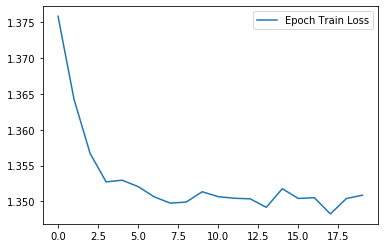

In [21]:
plt.plot(epochLossTrain, label = "Epoch Train Loss")
# plt.plot(epochLossValidate, label = "Epoch Validate Loss")
plt.legend(loc = "upper right")

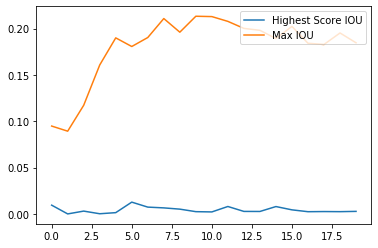

In [22]:
# plt.plot(epochLossTrain, label = "Epoch Train Loss"
plt.plot(epochAccBestScore, label = "Highest Score IOU")
plt.plot(epochAccValidate, label = "Max IOU")
plt.legend(loc = "upper right")

iou:  0.07001392874298105


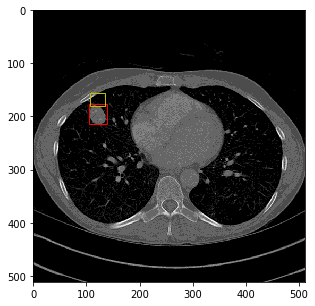

iou:  0.032383392554037424


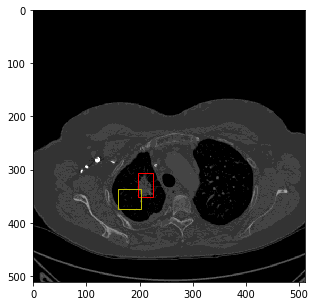

iou:  0.3039725712747845


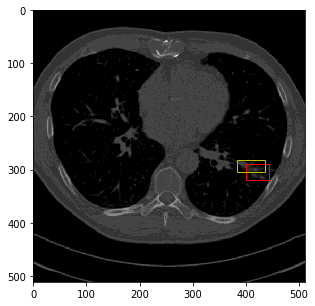

7 35 highest:  3


In [24]:
count = 0
highestScore = 0
# for index, row in test_data.iterrows():
for images, targets in (dataloader['test']):
    with torch.no_grad():
        model.eval()
        images = move_to(images,device)
        pred = model(images) # Pass the image to the model



        for i, out in enumerate(pred):
            pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
            pred_score = list(out['scores'].cpu().detach().numpy())
            pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]

            max_score_index = pred_score.index(max(pred_score))
            
            max_score = pred_boxes[max_score_index]
            list_box = []
            for lab in targets[i]['boxes'].numpy():
                list_box.append(lab[0]) #xmin
                list_box.append(lab[1]) #ymin
                list_box.append(lab[2]) #xmax
                list_box.append(lab[3]) #ymax
            if (bb_intersection_over_union((list_box),max_score) > 0):
                print("iou: ",bb_intersection_over_union((list_box),(pred_boxes[max_score_index])))
                fig,ax = plt.subplots(1, figsize=(5,5))
                ax.imshow(images[i][1].cpu().detach().squeeze().numpy(), cmap='gray')
                label = patches.Rectangle((list_box[0], list_box[1] ),(list_box[2] - list_box[0]),(list_box[3] - list_box[1]),linewidth=1,edgecolor='r',facecolor='none')
                maxScore = patches.Rectangle((max_score[0], max_score[1] ),(max_score[2] - max_score[0]),(max_score[3] - max_score[1]),linewidth=1,edgecolor='y',facecolor='none')
                ax.add_patch(label)
                ax.add_patch(maxScore)
                plt.show()
                highestScore += 1
            else:
                at_least_once = False
                for enu, ind in enumerate(pred_boxes):   
                    if (bb_intersection_over_union((list_box),(ind)) > .4):
                            at_least_once = True
#                             print("prediction box area: ", (ind[2] - ind[0]) * (ind[3] - ind[1]), "box area: ", (list_box[2] - list_box[0]) * (list_box[3] - list_box[1]))
#                             print("highest score:" ,max(pred_score), " min: ", min(pred_score))
#                             print("confidence: ", enu, " predicted score:" , pred_score[enu], "iou:", bb_intersection_over_union((list_box),(ind)))
#                             print(pred_score)
#                             fig,ax = plt.subplots(1, figsize=(5,5))
#                             ax.imshow(images[i][1].cpu().detach().squeeze().numpy(), cmap='gray')
#                             label = patches.Rectangle((list_box[0], list_box[1] ),(list_box[2] - list_box[0]),(list_box[3] - list_box[1]),linewidth=1,edgecolor='r',facecolor='none')
#                             predicted = patches.Rectangle((ind[0], ind[1] ),(ind[2] - ind[0]),(ind[3] - ind[1]),linewidth=1,edgecolor='b',facecolor='none')
#                             maxScore = patches.Rectangle((max_score[0], max_score[1] ),(max_score[2] - max_score[0]),(max_score[3] - max_score[1]),linewidth=1,edgecolor='y',facecolor='none')
#                             ax.add_patch(label)
#                             ax.add_patch(predicted)
#                             ax.add_patch(maxScore)
#                             plt.show()
                if at_least_once:
                    count += 1
    
print(count, len(test_data), "highest: ", highestScore)
